### Data preparation


In [1]:
from scipy.io import loadmat
from matplotlib.pyplot import (
    figure,
    subplot,
    plot,
    xlabel,
    ylabel,
    title,
    yticks,
    show,
    legend,
    imshow,
    cm,
)
import scipy.linalg as linalg
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
file_path = r"C:\Users\Dell\Desktop\Git\Machine-Learning-report1\MAIN_Movies_DS.xls"
doc = xlrd.open_workbook(file_path).sheet_by_index(0)

In [3]:
# Extract attribute names
attributeNames = doc.row_values(0, 2, 10)

# Extract MPAA names to python list, then encode with integers (dict)
mpaa = doc.col_values(3, 2, 636)
mpaa_name = sorted(set(mpaa))  # set because it deletes the duplicates
mpaaDict = dict(zip(mpaa_name, range(5)))

# Extract names to python list, then encode with integers (dict)
# the column Genre was moved to this position in excel
genre = doc.col_values(2, 2, 636)
genre_name = sorted(set(genre))
genreDict = dict(zip(genre_name, range(18)))

title = doc.col_values(1, 2, 636)
title_name = sorted(set(title))
titleDict = dict(zip(title_name, range(627)))

rating = doc.col_values(8, 2, 636)
rating_name = sorted(set(rating))
ratDict = dict(zip(rating_name, range(627)))

In [4]:
# Extract vector y, convert to NumPy array
y_mpaa = np.array([mpaaDict[value] for value in mpaa])
y_genre = np.array([genreDict[value] for value in genre])
y_title = np.array([titleDict[value] for value in title])
y_rat = np.array([ratDict[value] for value in rating])

In [5]:
# Create a dataframe from the data
data = pd.DataFrame(
    {
        "MPAA_Rating": y_mpaa,
        "genre": y_genre,
        "title": y_title,
        "Budget": doc.col_values(4, 2, 636),
        "Gross": doc.col_values(5, 2, 636),
        "release_date": doc.col_values(6, 2, 636),
        "runtime": doc.col_values(7, 2, 636),
        "rating": doc.col_values(8, 2, 636),
        "rating_count": doc.col_values(9, 2, 636),
    }
)

In [6]:
# DATA CLEANING
# Remove duplicates based on the "title" column
data = data.drop_duplicates(subset="title", keep="first")
data.dropna(inplace=True)

In [7]:
data

,MPAA_Rating,genre,title,Budget,Gross,release_date,runtime,rating,rating_count
0,1,3,129,7500000.0,145793296.0,32855.0,99.0,7.4,91075.0
1,1,4,583,13000000.0,71079915.0,32717.0,100.0,7.2,91415.0
2,3,15,63,14000000.0,161001698.0,32862.0,145.0,7.2,91415.0
3,1,5,155,15000000.0,84431625.0,32619.0,107.0,7.5,101702.0
4,1,6,586,15000000.0,79258538.0,32736.0,100.0,7.0,77659.0
...,...,...,...,...,...,...,...,...,...
629,2,0,318,250000000.0,765199095.0,44477.0,163.0,7.3,323556.0
630,2,10,624,55000000.0,106457.0,44512.0,115.0,7.5,82101.0
631,2,0,594,110000000.0,212500000.0,44470.0,157.0,6.0,180165.0
632,2,3,338,17000000.0,115400000.0,41187.0,112.0,4.4,276.0


## Regression part a


### 1:

Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

That's a line to take the dataset saved from another file


ENCODING


In [22]:
## ONE OUT OF K ENCODING
columns_to_encode = ["MPAA_Rating", "genre"]

# Apply one-hot encoding using get_dummies with dtype=int
data_encoded = pd.get_dummies(
    data, columns=columns_to_encode, prefix=columns_to_encode, dtype=int
)

# Display the updated DataFrame with one-hot encoded columns using 0 and 1
# print(data_encoded.head())

STANDARDIZING


In [32]:
columns_to_standardize = [
    "Budget",
    "Gross",
    "release_date",
    "runtime",
    "rating_count",
]

# Create a StandardScaler instance with custom mean and standard deviation
# custom_scaler_std = StandardScaler(with_mean=True, with_std=True)


# Fit and transform the selected columns using the custom scaler
# data_encoded[columns_to_standardize] = custom_scaler_std.fit_transform(
#     data_encoded[columns_to_standardize]
# )

custom_scaler = StandardScaler()
data_encoded[columns_to_standardize] = pd.DataFrame(
    custom_scaler.fit_transform(data_encoded[columns_to_standardize]),
    columns=columns_to_standardize,
)


# ## It gives the same result also without this process
# # Adjust mean and standard deviation to the desired values
# desired_mean = 0
# desired_std = 1

# for column in columns_to_standardize:
#     data_encoded[column] = (data_encoded[column] - data_encoded[column].mean()) * (
#         desired_std / data_encoded[column].std()
#     ) + desired_mean

# # Display the updated DataFrame
print(data_encoded)

     title    Budget     Gross  release_date   runtime  rating  rating_count  \
0      129 -1.280144 -0.849679     -1.642283 -0.891535     7.4     -0.819360   
1      583 -1.198486 -1.070382     -1.683939 -0.846521     7.2     -0.818243   
2       63 -1.183639 -0.804754     -1.640170  1.179098     7.2     -0.818243   
3      155 -1.168792 -1.030941     -1.713520 -0.531425     7.5     -0.784444   
4      586 -1.168792 -1.046223     -1.678203 -0.846521     7.0     -0.863440   
..     ...       ...       ...           ...       ...     ...           ...   
620    140       NaN       NaN           NaN       NaN     6.6           NaN   
622    186       NaN       NaN           NaN       NaN     6.4           NaN   
623     40       NaN       NaN           NaN       NaN     8.4           NaN   
624    603       NaN       NaN           NaN       NaN     7.5           NaN   
625    163       NaN       NaN           NaN       NaN     7.2           NaN   

     MPAA_Rating_0  MPAA_Rating_1  MPAA

1. Split your data into features (independent variables) and the target variable (Gross)


In [29]:
# data_encoded = data_encoded.drop(columns="title")
data_encoded.dropna(inplace=True)
X_std = data_encoded.drop(columns="rating")  # Features (indipendent variables)
y = data_encoded["rating"]  # Target variable (dipendent variable)

2. Define a range of values for the regularization parameter λ (alpha) that you want to test.

These values were decided by trying different combinations of them and how the plots were


In [18]:
lambdas = np.arange(0, 300, 1, dtype="float")

3. Perform 10-fold cross-validation with Ridge regression for each value of λ


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, random_state=42, test_size=0.3
)

In [31]:
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

errors = []
errors_r2 = []
ridge_results = {}
best_error = 1

best_lambda = None

for lambda_i in lambdas:
    model = Ridge(alpha=lambda_i)

    # 10 fold cross validation

    scores = cross_val_score(model, X_train, y_train, cv=10)

    mean_score = scores.mean()

    # generalization error for lambda_i

    gen_err = 1 - mean_score

    errors.append(gen_err)

    # Ridge Model Fernando
    lr = Ridge(alpha=lambda_i)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        lr, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_i] = ridge_mse

    if gen_err < best_error:
        best_error = gen_err  # update the lowest generalization error
        best_lambda = lambda_i  # update the best lambda

    y_pred = cross_val_predict(model, X_test, y_test, cv=10)  # Model previsions
    r_2 = r2_score(y_test, y_pred)
    # number of misclassified observations
    errors_r2.append(r_2)
print(errors_r2)

print(f"best error = {best_error}, best lambda = {best_lambda}")

[0.009414018485737086, 0.09135498925839503, 0.11391728970772452, 0.12341213533835782, 0.12777979768578207, 0.12962395424570095, 0.1300782713297849, 0.12972021643035425, 0.1288736516543092, 0.12773195436483287, 0.12641556502011886, 0.12500166773106847, 0.12354064818056998, 0.12206573429978329, 0.12059888916739037, 0.11915453651612629, 0.11774198071484099, 0.11636701377249259, 0.11503300193746324, 0.11374163138904869, 0.11249342619692504, 0.11128811159563445, 0.11012487068125332, 0.10900252677279498, 0.10791967338194464, 0.10687476692797038, 0.10586619276404796, 0.1048923119683759, 0.10395149420648753, 0.10304214047339999, 0.10216269846870252, 0.10131167260687735, 0.1004876301266856, 0.09968920437436768, 0.09891509605239002, 0.09816407301837127, 0.09743496906647153, 0.0967266820109457, 0.09603817130803394, 0.09536845539018468, 0.09471660884020972, 0.09408175949828435, 0.09346308556873273, 0.09285981277411581, 0.09227121158958906, 0.09169659457965307, 0.09113531385134421, 0.09058675863192

Ridge results:  {0.0: 0.6882631945735136, 1.0: 0.6836433229677186, 2.0: 0.6814208128479973, 3.0: 0.680072256119249, 4.0: 0.679200559501683, 5.0: 0.678639208327476, 6.0: 0.6782970880886541, 7.0: 0.6781165595863736, 8.0: 0.6780581234869707, 9.0: 0.6780934010653255, 10.0: 0.6782013706183018, 11.0: 0.6783661218398418, 12.0: 0.6785754165290065, 13.0: 0.6788197197584269, 14.0: 0.6790915244838549, 15.0: 0.6793848681968561, 16.0: 0.6796949798197005, 17.0: 0.6800180173803756, 18.0: 0.6803508703565291, 19.0: 0.6806910089212418, 20.0: 0.68103636772492, 21.0: 0.6813852554438855, 22.0: 0.6817362837765749, 23.0: 0.682088311270374, 24.0: 0.6824403985642216, 25.0: 0.6827917724934253, 26.0: 0.6831417971281837, 27.0: 0.6834899502761432, 28.0: 0.6838358043196148, 29.0: 0.6841790105129087, 30.0: 0.6845192860577006, 31.0: 0.6848564034209008, 32.0: 0.6851901814719417, 33.0: 0.6855204781032546, 34.0: 0.685847184065278, 35.0: 0.6861702178001952, 36.0: 0.6864895211002189, 37.0: 0.6868050554491701, 38.0: 0.6871

<Figure size 800x500 with 0 Axes>

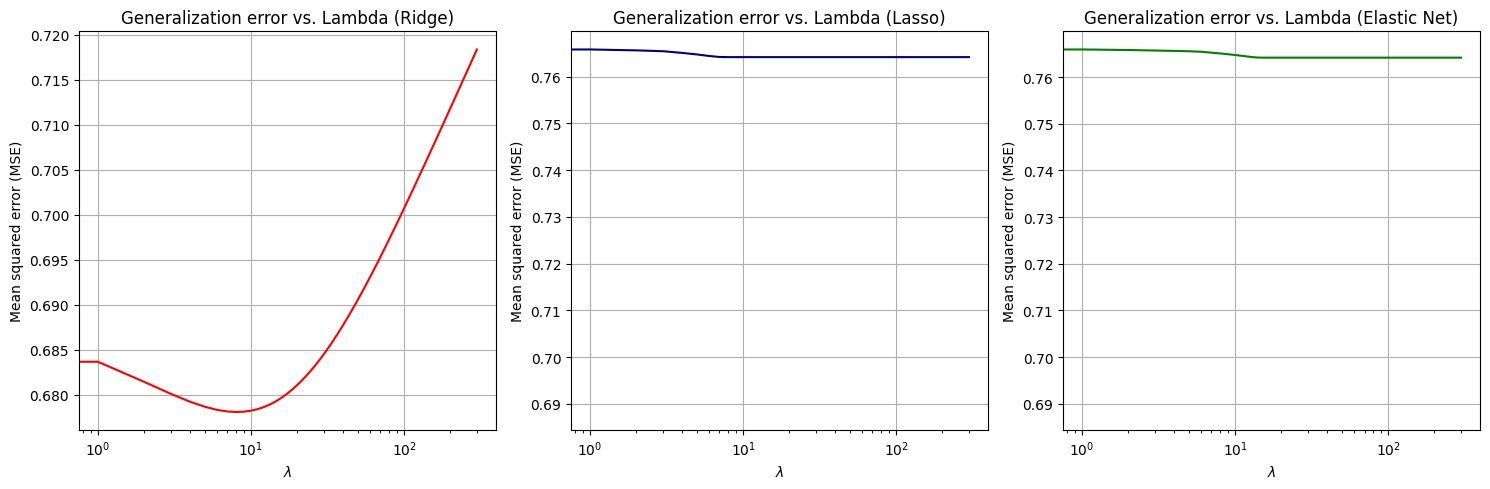

In [33]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Diccionarios para almacenar los resultados de cada modelo
ridge_results = {}
lasso_results = {}
elastic_net_results = {}

# Itera a través de los valores de lambda y realiza la validación cruzada
# Para cada lambda se obtiene un resultado el qual se almacena en los diccionarios declarados arriba.
# Tres tipos de cross validation diferentes.
for lambda_val in lambdas:
    # Ridge Model
    ridge_model = Ridge(alpha=lambda_val)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        ridge_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_val] = ridge_mse

    # Lasso Model
    lasso_model = Lasso(alpha=lambda_val)
    lasso_scores = cross_val_score(
        lasso_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    lasso_mse = -np.mean(lasso_scores)
    lasso_results[lambda_val] = lasso_mse

    # Elastic Net Model
    elastic_net_model = ElasticNet(
        alpha=lambda_val, l1_ratio=0.5
    )  # l1_ratio = 0.5 para balancear L1 y L2
    elastic_net_scores = cross_val_score(
        elastic_net_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    elastic_net_mse = -np.mean(elastic_net_scores)
    elastic_net_results[lambda_val] = elastic_net_mse


print("Ridge results: ", ridge_results)
print("Lasso results: ", lasso_results)
print("ElasticNet results: ", elastic_net_results)

# Crear una figura con una fila y tres columnas
plt.figure(figsize=(8, 5))
plt.subplots(1, 3, figsize=(15, 5))

# Graficar los resultados para Ridge
plt.subplot(1, 3, 1)
plt.plot(
    lambdas, list(ridge_results.values()), linestyle="-", color="red", label="Ridge"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Ridge)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Lasso
plt.subplot(1, 3, 2)
plt.plot(
    lambdas, list(lasso_results.values()), linestyle="-", color="navy", label="Lasso"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Lasso)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Elastic Net
plt.subplot(1, 3, 3)
plt.plot(
    lambdas,
    list(elastic_net_results.values()),
    linestyle="-",
    color="g",
    label="Elastic Net",
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Elastic Net)")
plt.xscale("log")
plt.grid(True)

# Ajustar los subplots para evitar solapamiento
plt.tight_layout()

# Guardar la figura como un archivo PDF
# plt.savefig("combined_regression_results.pdf")

# Mostrar la figura en la pantalla
plt.show()

In [35]:
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_model.predict(X_test)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate R2
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.6123829881634592
MSE: 0.6157412906358584
RMSE: 0.7846918443795999
R2: 0.098734097109342


4. Find the λ that gives the lowest generalization error


Values of coefficients are the weigths for each feature and intercept is the bias term
$$y=(biasterm) + weigths*(features)$$


In [20]:
# Create and train a Ridge regression model
model = Ridge(alpha=best_lambda)  # Use the best_alpha value you've determined
model.fit(X_scaled, y_scaled)  # X is your feature matrix, y is your target variable

# Access the coefficients
coefficients = model.coef_  # Coefficients (weights)
intercept = model.intercept_  # Intercept (bias term)

NameError: name 'X_scaled' is not defined

In [ ]:
coefficients

array([[-2.86156942e+07, -1.16074123e+07,  1.65149124e+08, ...,
         3.02954051e+07,  3.48629029e+06,  9.02593886e+07],
       [-2.86247395e+07, -1.16423642e+07,  1.64838520e+08, ...,
         3.03703145e+07,  3.56994996e+06,  9.01076445e+07],
       [-2.86332294e+07, -1.16769243e+07,  1.64529892e+08, ...,
         3.04440896e+07,  3.65302577e+06,  8.99567861e+07],
       ...,
       [-2.60958097e+07, -1.43976550e+07,  1.25746246e+08, ...,
         3.45909460e+07,  1.26391558e+07,  7.08202056e+07],
       [-2.60759814e+07, -1.44007142e+07,  1.25609921e+08, ...,
         3.45885312e+07,  1.26626416e+07,  7.07530273e+07],
       [-2.60561494e+07, -1.44037149e+07,  1.25473994e+08, ...,
         3.45860148e+07,  1.26859860e+07,  7.06860452e+07]])

Index(['MPAA_Rating', 'genre', 'Budget', 'release_date', 'runtime', 'rating',
       'rating_count'],
      dtype='object')


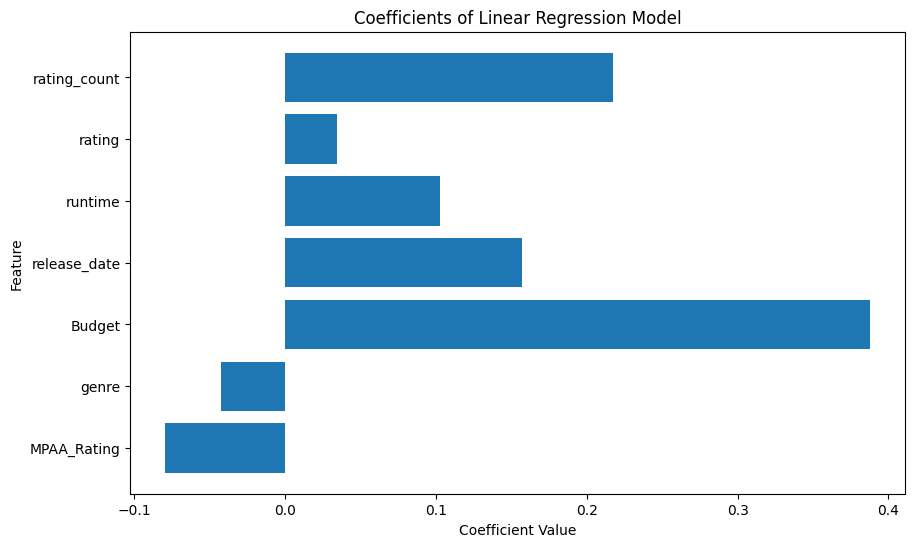

In [ ]:
feature_names = X_scaled.columns
print(feature_names)
# Creare un grafico a barre per visualizzare i coefficienti
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficients of Linear Regression Model")
plt.show()

In [ ]:
intercept

1.3861592516270184e-16

This is the plot as 14.2 in the book


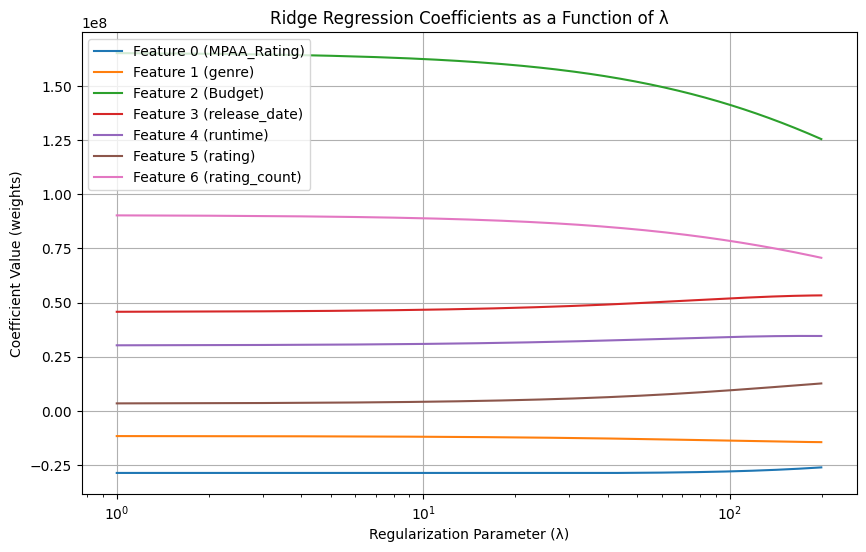

In [ ]:
coefficients = []
lambdas1 = np.arange(1, 100000, 20, dtype=float)

for alpha in lambdas:
    # Create and fit a Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_scaled, y)  # Use your transformed data

    # Get the coefficients for this λ
    coef = model.coef_
    coefficients.append(coef)

# Convert coefficients to a NumPy array
coefficients = np.array(coefficients)

# Create a plot to visualize the coefficients
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.semilogx(
        lambdas, coefficients[:, i], label=f"Feature {i} ({X_scaled.columns[i]})"
    )
plt.title("Ridge Regression Coefficients as a Function of λ")
plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Coefficient Value (weights)")
plt.legend()
plt.grid()
plt.show()

## Regression part a - One-ou-of-k ENCODING


In [ ]:
# data = data.drop(columns="title")

# Initialize the scaler

scaler = StandardScaler()


# Fit the scaler to your feature matrix and transform it

data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=X.columns)
data_scaled

,MPAA_Rating,genre,Budget,Gross,release_date,runtime,rating,rating_count
0,-1.101696,-0.447330,-1.285567,-0.857075,-1.647076,-0.894319,0.512297,-0.818831
1,-1.101696,-0.236465,-1.204122,-1.078317,-1.688438,-0.849603,0.282489,-0.817722
2,1.392560,2.083051,-1.189314,-0.812040,-1.644978,1.162614,0.282489,-0.817722
3,-1.101696,-0.025600,-1.174506,-1.038780,-1.717810,-0.536591,0.627202,-0.784183
4,-1.101696,0.185265,-1.174506,-1.054099,-1.682743,-0.849603,0.052680,-0.862572
...,...,...,...,...,...,...,...,...
621,0.145432,-1.079926,2.305414,0.977115,1.836262,1.967501,0.397393,-0.060860
622,0.145432,1.028725,-0.582179,-1.288484,1.846753,-0.178864,0.627202,-0.848089
623,0.145432,-1.079926,0.232270,-0.659543,1.834164,1.699205,-1.096364,-0.528366
624,0.145432,-0.447330,-1.144889,-0.947076,0.850186,-0.313012,-2.934834,-1.114868


In [ ]:
# Assuming 'df' is your DataFrame
# Select the columns to one-hot encode
columns_to_encode = ["MPAA_Rating", "genre"]

# Apply one-hot encoding using get_dummies
df_encoded = pd.get_dummies(data, columns=columns_to_encode, prefix=columns_to_encode)

# Display the updated DataFrame with one-hot encoded columns
print(df_encoded.head())

       Budget        Gross  release_date  runtime  rating  rating_count  \
0   7500000.0  145793296.0       32855.0     99.0     7.4       91075.0   
1  13000000.0   71079915.0       32717.0    100.0     7.2       91415.0   
2  14000000.0  161001698.0       32862.0    145.0     7.2       91415.0   
3  15000000.0   84431625.0       32619.0    107.0     7.5      101702.0   
4  15000000.0   79258538.0       32736.0    100.0     7.0       77659.0   

   MPAA_Rating_0  MPAA_Rating_1  MPAA_Rating_2  MPAA_Rating_3  ...  genre_7  \
0          False           True          False          False  ...    False   
1          False           True          False          False  ...    False   
2          False          False          False           True  ...    False   
3          False           True          False          False  ...    False   
4          False           True          False          False  ...    False   

   genre_8  genre_9  genre_10  genre_11  genre_12  genre_13  genre_14  \
0

In [ ]:
X_scaled = df_encoded.drop(columns="Gross")
# X_std = pd.DataFrame(X_scaled.fit_transform(), columns=X_scaled.columns)

y_scaled = data_scaled["Gross"]

# X_std.head(5)
scaler = StandardScaler()
# Fit the scaler to your feature matrix and transform it

X_std = pd.DataFrame(scaler.fit_transform(X_std), columns=X_std.columns)
X_std

,Budget,release_date,runtime,rating,rating_count,MPAA_Rating_0,MPAA_Rating_1,MPAA_Rating_2,MPAA_Rating_3,genre_0,...,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16
0,-1.285567,-1.647076,-0.894319,0.512297,-0.818831,-0.212309,1.699470,-0.947085,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
1,-1.204122,-1.688438,-0.849603,0.282489,-0.817722,-0.212309,1.699470,-0.947085,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
2,-1.189314,-1.644978,1.162614,0.282489,-0.817722,-0.212309,-0.588419,-0.947085,1.846199,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,8.279828,-0.098374
3,-1.174506,-1.717810,-0.536591,0.627202,-0.784183,-0.212309,1.699470,-0.947085,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
4,-1.174506,-1.682743,-0.849603,0.052680,-0.862572,-0.212309,1.699470,-0.947085,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2.305414,1.836262,1.967501,0.397393,-0.060860,-0.212309,-0.588419,1.055872,-0.541653,2.119252,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
622,-0.582179,1.846753,-0.178864,0.627202,-0.848089,-0.212309,-0.588419,1.055872,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,25.00,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
623,0.232270,1.834164,1.699205,-1.096364,-0.528366,-0.212309,-0.588419,1.055872,-0.541653,2.119252,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374
624,-1.144889,0.850186,-0.313012,-2.934834,-1.114868,-0.212309,-0.588419,1.055872,-0.541653,-0.471865,...,-0.208167,-0.08973,-0.156684,-0.04,-0.1398,-0.216386,-0.254216,-0.261265,-0.120775,-0.098374


In [ ]:
lambdas = np.arange(0, 300, 1, dtype="float")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_scaled, random_state=42, test_size=0.3
)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incr

Ridge results:  {0.0: 0.4666286184973375, 1.0: 0.44200023083623663, 2.0: 0.4419005719085546, 3.0: 0.44180962687671854, 4.0: 0.44172699798389176, 5.0: 0.4416523097776103, 6.0: 0.44158520764792375, 7.0: 0.44152535647550284, 8.0: 0.44147243938034064, 9.0: 0.4414261565625618, 10.0: 0.4413862242276654, 11.0: 0.4413523735892368, 12.0: 0.44132434994281067, 13.0: 0.44130191180514516, 14.0: 0.441284830113683, 15.0: 0.4412728874814448, 16.0: 0.4412658775030163, 17.0: 0.4412636041076775, 18.0: 0.4412658809560536, 19.0: 0.44127253087698887, 20.0: 0.4412833853416143, 21.0: 0.4412982839718431, 22.0: 0.44131707408074944, 23.0: 0.44133961024250346, 24.0: 0.4413657538897183, 25.0: 0.44139537293624437, 26.0: 0.44142834142359727, 27.0: 0.44146453918935513, 28.0: 0.4415038515559885, 29.0: 0.44154616903870475, 30.0: 0.44159138707100476, 31.0: 0.44163940574673877, 32.0: 0.4416901295775519, 33.0: 0.4417434672646837, 34.0: 0.4417993314841696, 35.0: 0.44185763868455863, 36.0: 0.44191830889633127, 37.0: 0.44198

<Figure size 800x500 with 0 Axes>

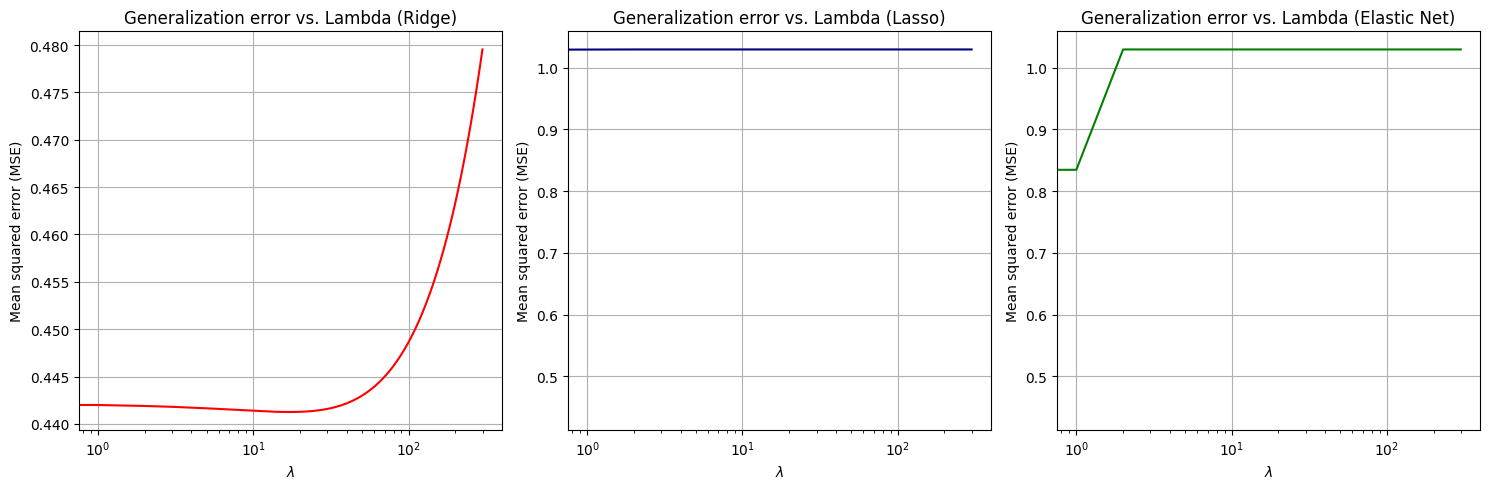

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Diccionarios para almacenar los resultados de cada modelo
ridge_results = {}
lasso_results = {}
elastic_net_results = {}

# Itera a través de los valores de lambda y realiza la validación cruzada
# Para cada lambda se obtiene un resultado el qual se almacena en los diccionarios declarados arriba.
# Tres tipos de cross validation diferentes.
for lambda_val in lambdas:
    # Ridge Model
    ridge_model = Ridge(alpha=lambda_val)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    ridge_scores = cross_val_score(
        ridge_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    ridge_mse = -np.mean(ridge_scores)
    ridge_results[lambda_val] = ridge_mse

    # Lasso Model
    lasso_model = Lasso(alpha=lambda_val)
    lasso_scores = cross_val_score(
        lasso_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    lasso_mse = -np.mean(lasso_scores)
    lasso_results[lambda_val] = lasso_mse

    # Elastic Net Model
    elastic_net_model = ElasticNet(
        alpha=lambda_val, l1_ratio=0.5
    )  # l1_ratio = 0.5 para balancear L1 y L2
    elastic_net_scores = cross_val_score(
        elastic_net_model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    elastic_net_mse = -np.mean(elastic_net_scores)
    elastic_net_results[lambda_val] = elastic_net_mse


print("Ridge results: ", ridge_results)
print("Lasso results: ", lasso_results)
print("ElasticNet results: ", elastic_net_results)

# Crear una figura con una fila y tres columnas
plt.figure(figsize=(8, 5))
plt.subplots(1, 3, figsize=(15, 5))

# Graficar los resultados para Ridge
plt.subplot(1, 3, 1)
plt.plot(
    lambdas, list(ridge_results.values()), linestyle="-", color="red", label="Ridge"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Ridge)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Lasso
plt.subplot(1, 3, 2)
plt.plot(
    lambdas, list(lasso_results.values()), linestyle="-", color="navy", label="Lasso"
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Lasso)")
plt.xscale("log")
plt.grid(True)

# Graficar los resultados para Elastic Net
plt.subplot(1, 3, 3)
plt.plot(
    lambdas,
    list(elastic_net_results.values()),
    linestyle="-",
    color="g",
    label="Elastic Net",
)
plt.xlabel("$λ$")
plt.ylabel("Mean squared error (MSE)")
plt.title("Generalization error vs. Lambda (Elastic Net)")
plt.xscale("log")
plt.grid(True)

# Ajustar los subplots para evitar solapamiento
plt.tight_layout()

# Guardar la figura como un archivo PDF
# plt.savefig("combined_regression_results.pdf")

# Mostrar la figura en la pantalla
plt.show()

In [ ]:
# Create and train a Ridge regression model
model = Ridge(alpha=best_lambda)  # Use the best_alpha value you've determined
model.fit(X_scaled, y_scaled)  # X is your feature matrix, y is your target variable

# Access the coefficients
coefficients = model.coef_  # Coefficients (weights)
intercept = model.intercept_  # Intercept (bias term)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.3748e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Index(['Budget', 'release_date', 'runtime', 'rating', 'rating_count',
       'MPAA_Rating_0', 'MPAA_Rating_1', 'MPAA_Rating_2', 'MPAA_Rating_3',
       'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5',
       'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11',
       'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16'],
      dtype='object')


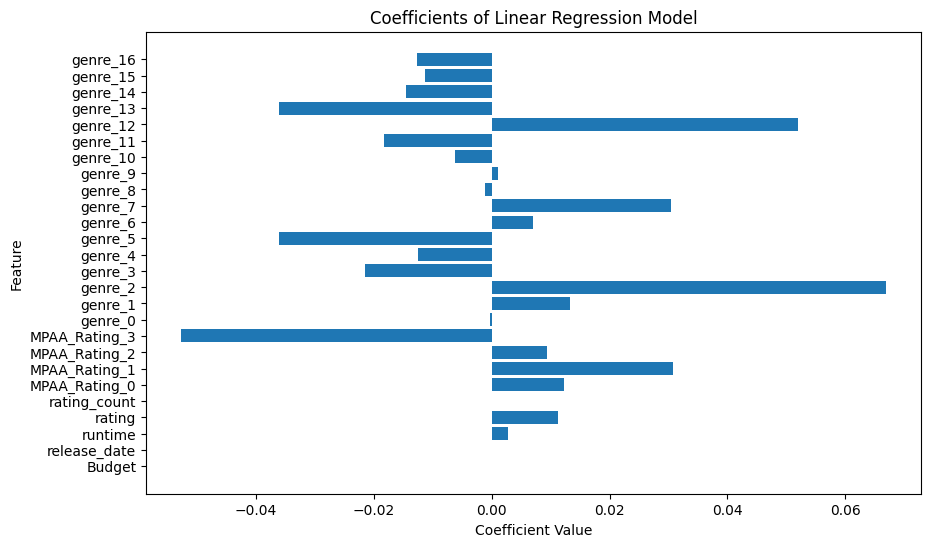

In [ ]:
feature_names = X_scaled.columns
print(feature_names)
# Creare un grafico a barre per visualizzare i coefficienti
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Coefficients of Linear Regression Model")
plt.show()

## Regression part b


In this section, we will compare three models: the regularized
linear regression model from the previous section, an artificial neural network (ANN) and a baseline.

We are interested in two questions:

- Is one model better than the other?
- Is either model better than a trivial baseline?.

We will attempt to answer
these questions with two-level cross-validation.


### 1 Implement two-level cross-validation

(see algorithm 6 of the lecture notes). We will use 2-level cross-validation to compare the models with K1 = K2 = 10 folds.

As a baseline model, we will apply a linear regression model with no features, i.e. it computes the mean of y on the training data, and use this value to predict y on the test data.

Make sure you can fit an ANN model to the data.

As complexity-controlling parameter for the ANN, we will use the number of hidden units5 h.
Based on a few test-runs, select a reasonable range of values for h (which should include h = 1), and describe the range of values you will use for h and λ.


The baseline model is a simple linear regression model that computes the mean of the target variable (y) on the training data and uses this mean value to predict y on the test data.


In [ ]:
import torch
import toolbox_functions
from sklearn import model_selection

Model for ANN analysis


In [ ]:
# Parameters for Neural Network
n_hidden_units = 1
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000
N, M = X.shape


def model_ANN():
    return torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
        torch.nn.Tanh(),  # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
        # no final tranfer function, i.e. "linear output"
    )


loss_fn = torch.nn.MSELoss()

In [ ]:
# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = model_selection.KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

for k, (train_index, test_index) in enumerate(outer_cv.split(X_scaled)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, outer_folds))

    X_par = X_scaled[train_index]
    y_par = y.to_numpy()[train_index]

    X_test = X_scaled[test_index]
    y_test = y.to_numpy()[test_index]

    ## BASELINE NO LAMBDA NO FEATURES
    # Calculate the mean of y in the training data
    y_mean = np.mean(y_par)

    # Create an array of predicted values using the mean
    y_pred_baseline = np.full(y_test.shape, y_mean)

    # Calculate the mean squared error (MSE) for the baseline model
    mse_baseline = ((y_pred_baseline - y_test) ** 2).mean()

    # Print or store the MSE for the baseline model
    print(f"Baseline MSE: {mse_baseline}")

    ## RIDGE REGRESSION
    lambdas = np.arange(1, 200, 1, dtype="float")

    # errors contains generalization error for each lambda
    errors_ridge = []
    best_error_lambda_i = 1
    best_lambda_i_ridge = None

    # RIDGE REGRESSION AS BEFORE
    for lambda_i in lambdas:
        ridge_model = Ridge(alpha=lambda_i)

        # 10 fold cross validation
        scores = cross_val_score(ridge_model, X_par, y_par, cv=inner_folds)
        mean_score = scores.mean()

        # generalization error for lambda_i
        gen_err_lambda_i_ridge = 1 - mean_score

        errors_ridge.append(gen_err_lambda_i_ridge)

        if gen_err_lambda_i_ridge < best_error_lambda_i:
            best_error_lambda_i = (
                gen_err_lambda_i_ridge  # update the lowest generalization error
            )
            best_lambda_i_ridge = lambda_i  # update the best lambda

    # print(errors_ridge)
    print(f"best error = {best_error_lambda_i}, best lambda = {best_lambda_i_ridge}")

    # ## ANN
    # # Some parameters for Neural Network are defined before the loop
    # errors_NN = []
    # # Convert training and test set for current CV fold, convert to tensors
    # X_par_NN = torch.Tensor(X_par)
    # y_par_NN = torch.Tensor(y_par)
    # X_test_NN = torch.Tensor(X_test)
    # y_test_NN = torch.Tensor(y_test)

    # net, final_loss, learning_curve = toolbox_functions.train_neural_net(
    #     model,
    #     loss_fn,
    #     X=X_par_NN,
    #     y=y_par_NN,
    #     n_replicates=n_replicates,
    #     max_iter=max_iter,
    # )

    # # Determine estimated class labels for test set
    # y_test_est = net(X_test_NN)

    # # Determine errors and errors
    # se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    # mse_NN = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    # errors_NN.append(mse_NN)  # store error rate for current CV fold
    # print("\n\tBest loss: {}\n".format(final_loss))


Crossvalidation fold: 1/10
Baseline MSE: 1.4380800393496336e+17
best error = 0.6658066062032819, best lambda = 136.0

Crossvalidation fold: 2/10
Baseline MSE: 7.084153319777284e+16
best error = 0.6341769788136511, best lambda = 143.0

Crossvalidation fold: 3/10
Baseline MSE: 1.0988902839912518e+17
best error = 0.6782475387240069, best lambda = 157.0

Crossvalidation fold: 4/10
Baseline MSE: 7.825253542125474e+16
best error = 0.6831424324629112, best lambda = 150.0

Crossvalidation fold: 5/10
Baseline MSE: 6.346318145488119e+16
best error = 0.660499689355105, best lambda = 182.0

Crossvalidation fold: 6/10
Baseline MSE: 1.7190419161088867e+17
best error = 0.6185822295404305, best lambda = 152.0

Crossvalidation fold: 7/10
Baseline MSE: 1.1541300009163043e+17
best error = 0.6746236714978036, best lambda = 151.0

Crossvalidation fold: 8/10
Baseline MSE: 1.946801032828448e+17
best error = 0.6613183353801573, best lambda = 121.0

Crossvalidation fold: 9/10
Baseline MSE: 1.0105318378298698e

In [ ]:
from sklearn.model_selection import train_test_split

test_proportion = 0.3

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_proportion
)

In [ ]:
from sklearn.linear_model import LinearRegression

# Create the baseline model
baseline_model = LinearRegression()

# Fit the model to the mean of the training target variable
baseline_model.fit(X_train, y_train)

# Make predictions using the trained baseline model
baseline_predictions = baseline_model.predict(X_test)

For the ANN model, you need to set up a range of values for the number of hidden units (h) and the regularization parameter (λ).


In [ ]:
# Define a range of values for hidden units (h)
hidden_units_range = [1, 10, 20, 30, 40, 50]

# Define a range of values for the regularization parameter (λ)
lambda_range = np.arange(1, 200, 1, dtype=float)